## Project Title: Anaylsis for Good Seed 

Introduction:

The supermarket chain, Good Seed needs support in preventing the sale of alcohol to minors. This project aims to create and evaluate models to verify ages using computer vision techniuqes. 

In [1]:

#Loading Libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import tensorflow as tf 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten 
from tensorflow.keras.optimizers import Adam 


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
#Load the csv file 
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Quick overview of dataset 
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
#Summary of dataset 
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
#General stats 
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
#Checking for missing values 
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [7]:
#Checking for duplicates 
labels.duplicated().sum()

0

Description: No missing values or duplicates in the dataframe. Will need to examine distribution of dataframe next. This is a regression task. 

## EDA

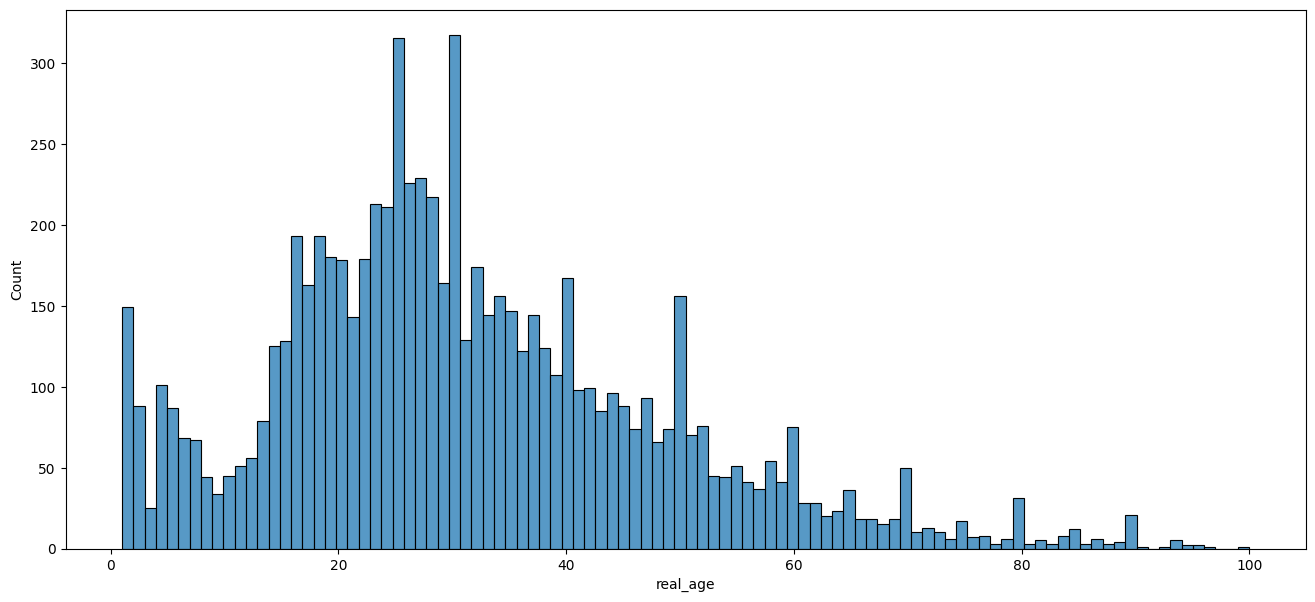

In [8]:
#Examining distribution in the dataframe 
plt.figure(figsize=(16,7))
sns.histplot(labels['real_age'],bins = 100)
plt.show()

Description: Right skewed histogram indicating asymmetrical concentration of the data on the lower end of the scale. This means most of the data in the real_age column is from those under age 40. 


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Nice chart 👍 
    
</div>
<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
However, I would change `Count` to `Number of photos`, for instance.
    
</div>

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age', 
    target_size = (32, 32),  
    class_mode = 'raw',
    seed = 12345)

Found 7591 validated image filenames.


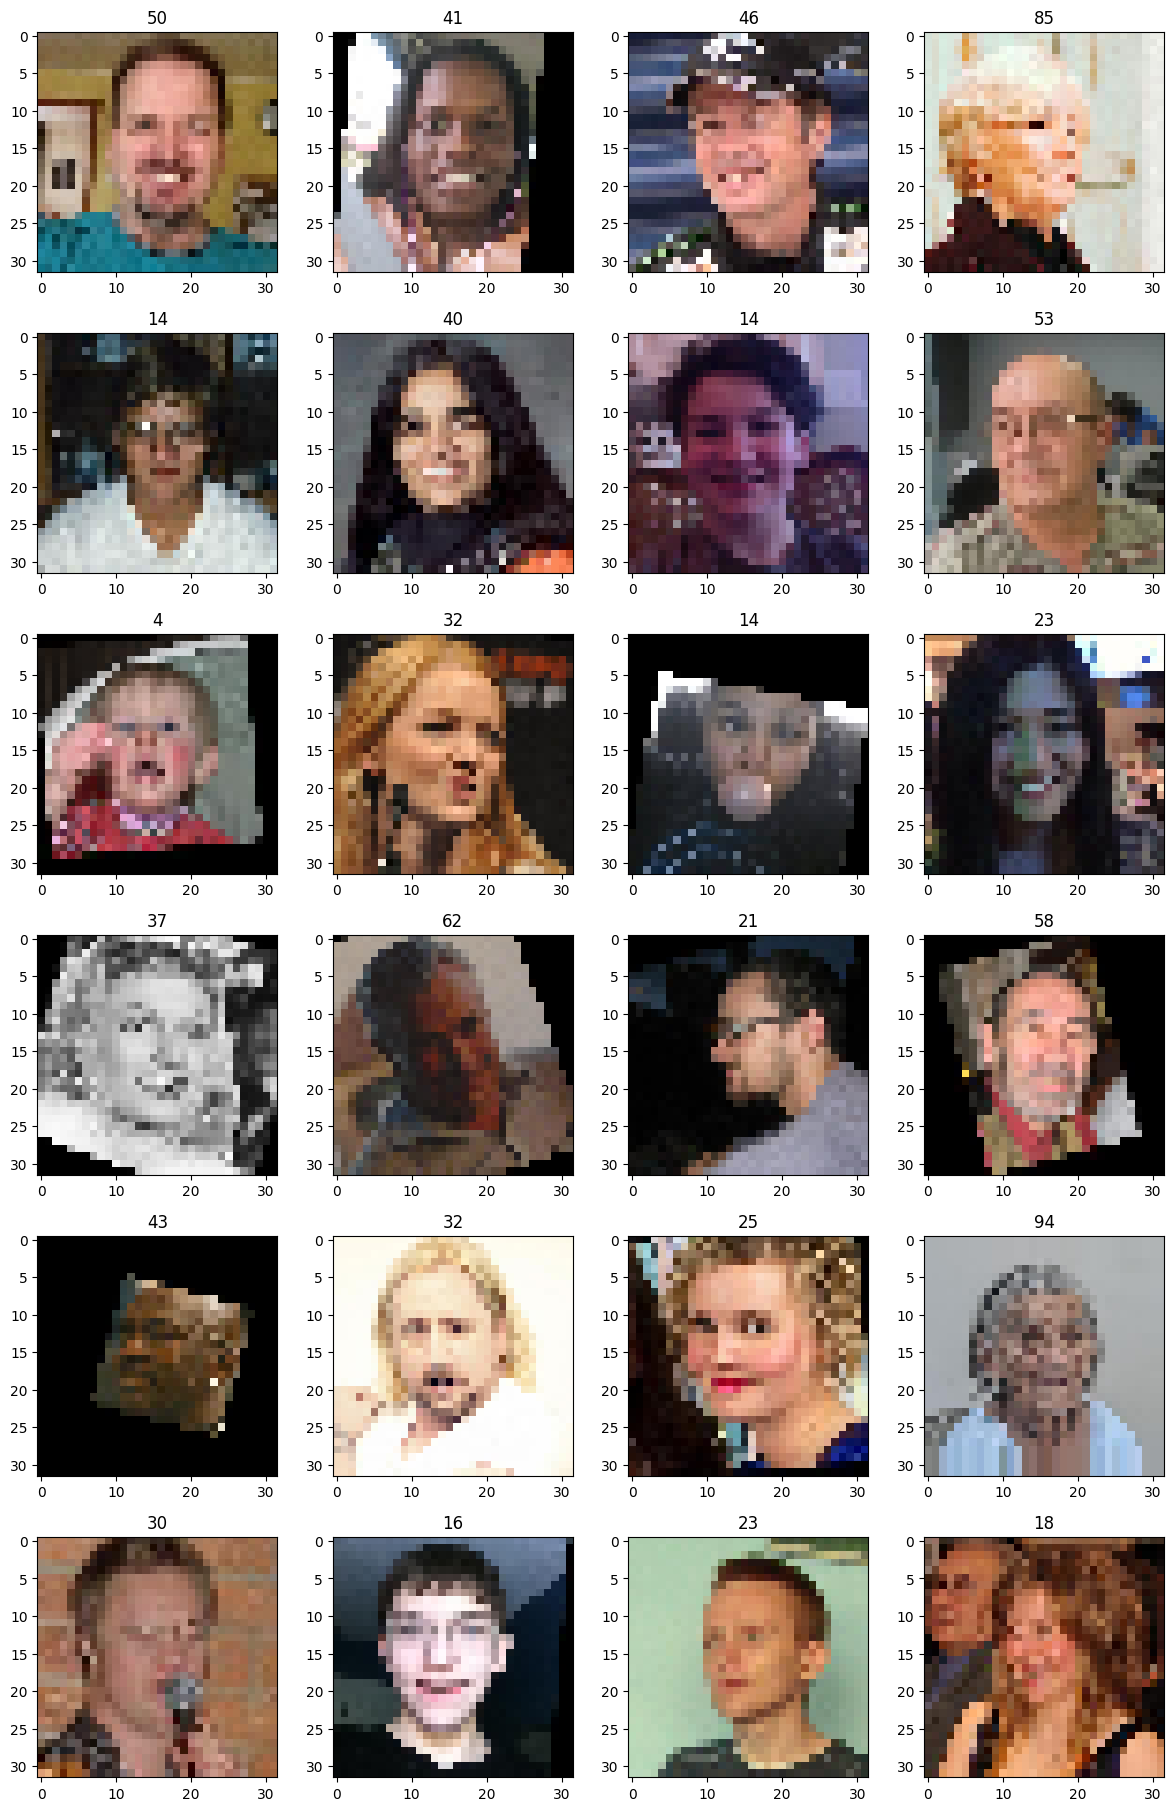

In [10]:
def show_images(batch, predictions=None):
    fig = plt.figure(figsize=(12,24))

    for i in range (24):
        fig.add_subplot(8,4, i+1)
        plt.imshow(batch[0][i])
        title = batch [1][i]
        if predictions is not None:
            title = f'gt:{title},prediction:{round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

show_images(next(data_flow))

<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Consider using a larger target size. The images will look better. 
</div>


Description: Based on the image data it appears to be diverse in terms of age, gender, origin. This will support the model with making better predictions. 

### Findings

Description: This task is a regression task. The model has good reinforcement as based on the image data it appears to have a diverse set of examples. In addition, most of the data arises from the age distribution under age 40.

Next steps, will need the final layer to have one neuron because it has to return one single value as an output. Therefore, will need ot add it to the backbone of ResNet 50 by adding a Dense layer. There are no negative values due to the dataset we are examining. Therefore 'ReLu' activation should suffice to transform those values to zeros. The loss function will be MSE and the metric to examine will be MAE. MAE should be less then 8 for this exercise. 

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

    
Good conclusion.

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25, 
        rescale = 1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name', 
        y_col = 'real_age', 
        target_size = (224,224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345)

    return train_gen_flow

In [12]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory = path + 'final_files/',
        x_col = 'file_name', 
        y_col = 'real_age', 
        target_size = (224,244),
        batch_size = 16, 
        class_mode = 'raw', 
        subset = 'validation',
        seed = 12345)

    return test_gen_flow

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Yes, augmentation should help us here. It's great that you specify the `subset` parameter values. If we don't do this, the model will be trained and evaluated on the same data. 
    

The `class_mode` value is also correct. 

</div>
<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
I recommend using some variable for `seed`. 

</div>

In [13]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights = 'imagenet',
                       input_shape =input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1,activation='relu'))

    optimizer = Adam(lr=0.0025)
    model.compile(optimizer=optimizer, loss = 'mse', metrics= ['mae'])
    
    return model

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>


Correct! 
    
    
- `Dense(1, activation='relu')` is appropriate, since you are predicting a single value. Using 1 neuron makes sense here.
    

- Adam optimizer with learning rate 0.0025 is a solid and commonly used choice, well done. 


- The use of MSE loss and MAE as metric is also correct. MSE encourages precision, and MAE helps us interpret error scale in the same units as the target.

</div>

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)
    if validation_steps is None: 
        validation_steps = len(test_data)

    model.fit(train_data, 
              epochs = epochs,
              validation_data = test_data, 
              batch_size = batch_size, 
              steps_per_epoch = steps_per_epoch, 
              validation_steps = validation_steps, 
              verbose=1)

    return model

Description: Devised a ResNet50 neural network backbone and added a GlobalAveragePooling 2D and Dense 1 to obtain a regression output. ReLu activation function is used to eliminate negative values and an optimizer Adam with a learning rate of 0.0025.

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [15]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
   

You can use Markdown cell for your code and results: 

    ```python
    
    # code
    
    
    ```
    
Example:
    
</div>


```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

...



Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
```

## Conclusions

The aim of this model is to recognize the age of an individual based on photos. The model used was a ResNet50. ReLu activation was used to transform negative values into 0 and a final layer with one neuron to produce a single output obtained through regression. The loss function used was 'MSE' and the metric used to measure the success of the model was 'MAE'. 'MAE' obtained was 7.6512 which is well below the desired 8. 

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
Although the model shows small overfitting, it is still good. We can still think about further improvements. Sometimes it is possible to increase the dataset. What else can be done? Sometimes it may be helpful to try different data augmentation approaches. By the way, here's a good library [albumentations](https://github.com/albumentations-team/albumentations). Apart from this, we can consider introducing additional layers with some normalization methods. The optimization part is good. Adam is quite flexible, but you can still try other optimizers if you want. For example, AdamW sometimes shows better results. 



Regarding age verification, I would argue that we have some noticable limits here. It is much more reliable and much easier to just compare the id or passport photo to the customer's face. 

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training